In [1]:
from buildstock_query import BuildStockQuery
import pandas as pd
import os
os.environ['AWS_PROFILE'] = "nrel-aws-resbldg"
os.environ['AWS_DEFAULT_REGION'] = "us-west-2"
## annual table - from SQL
## timeseries tables - from timeseries (8760)

c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)
c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)
c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


# Query:

In [2]:
my_run = BuildStockQuery(db_name='gashpwh',
                        table_name='icf',
                        workgroup='gashpwh',
                        buildstock_type='resstock')

INFO:buildstock_query.query_core:Loading icf ...
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:buildstock_query.query_core:3 queries cache read from icf_query_cache.pkl.
INFO:buildstock_query.query_core:3 queries cache is updated.
INFO:buildstock_query.main:Getting Success counts...
INFO:buildstock_query.report_query:Checking integrity with ts_tables ...
INFO:buildstock_query.query_core:3 queries cache saved to icf_query_cache.pkl


        Fail  Invalid Success    Sum
upgrade                             
0         42        0   15955  15997
Annual and timeseries tables are verified to have the same number of buildings.
All buildings are verified to have the same number of (8760) timeseries rows.


# Dataframe from Query:

In [3]:
res_df = my_run.get_results_csv()
res_df.columns

INFO:buildstock_query.main:Making results_csv query ...
c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pyathena\pandas\result_set.py:273: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(
c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pyathena\pandas\result_set.py:273: DtypeWarning: Columns (10,183,184,185,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,481,482,505,521) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(


Index(['job_id', 'started_at', 'completed_at', 'completed_status',
       'apply_upgrade.applicable', 'apply_upgrade.upgrade_name',
       'apply_upgrade.reference_scenario', 'build_existing_model.ahs_region',
       'build_existing_model.aiannh_area', 'build_existing_model.applicable',
       ...
       'report_utility_bills.bills_propane_fixed_usd',
       'report_utility_bills.bills_propane_total_usd',
       'report_utility_bills.bills_total_usd',
       'report_utility_bills.bills_wood_cord_energy_usd',
       'report_utility_bills.bills_wood_cord_fixed_usd',
       'report_utility_bills.bills_wood_cord_total_usd',
       'report_utility_bills.bills_wood_pellets_energy_usd',
       'report_utility_bills.bills_wood_pellets_fixed_usd',
       'report_utility_bills.bills_wood_pellets_total_usd',
       'report_utility_bills.output_format'],
      dtype='object', length=545)

# Basic filtering example:
df = res_df.filter(regex='report_simulation_output.emissions')

# Dataframe for emissions:

In [46]:
# Creating a list of columns to keep in the res_df dataframe:
regex_patterns = ['report_simulation_output.emissions',
'build_existing_model.cec_climate_zone',
'build_existing_model.geometry_stories',
'build_existing_model.heating_fuel'
'build_existing_model.hot_water_distribution',
'build_existing_model.hot_water_fixtures',
'build_existing_model.hvac_heating_type_and_fuel',
'build_existing_model.income_recs_2020',
'build_existing_model.occupants',
'build_existing_model.sample_weight',
'build_existing_model.vacancy_status',
'build_existing_model.vintage',
'build_existing_model.water_heater_efficiency',
'build_existing_model.water_heater_fuel',
'build_existing_model.water_heater_in_unit',
'report_simulation_output.fuel_use',
'report_simulation_output.load_hot_water_tank_losses_m_btu'
]

filtered_dfs = [res_df.filter(regex=pattern) for pattern in regex_patterns]
df = pd.concat(filtered_dfs, axis=1)
df = df[df['build_existing_model.geometry_stories'].astype(float) <= 5.0]  # Limiting to <= 5 stories high
print(df['build_existing_model.geometry_stories'])

building_id
51        2
76        3
130       2
224       2
271       2
         ..
549843    3
549856    1
549858    3
549867    1
549895    2
Name: build_existing_model.geometry_stories, Length: 14173, dtype: object


In [6]:
# Outputting the full emissions dataset for easy viewing:
df.to_csv('emissions/df.csv', index=False)
res_df.to_csv('emissions/res_df.csv', index=False)

In [7]:
# Total CO2e number across all homes:
totalCO2e = "{:e}".format(df['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum())
print("total CO2e, lb = ", totalCO2e)

# Converting to metric tons:
# 1 pound = 0.00045359237 metric tons
print("total MtCO2e = ", (df['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum())*0.00045359237)

total CO2e, lb =  6.150304e+07
total MtCO2e =  27897.309122422106


# Sanity check plot

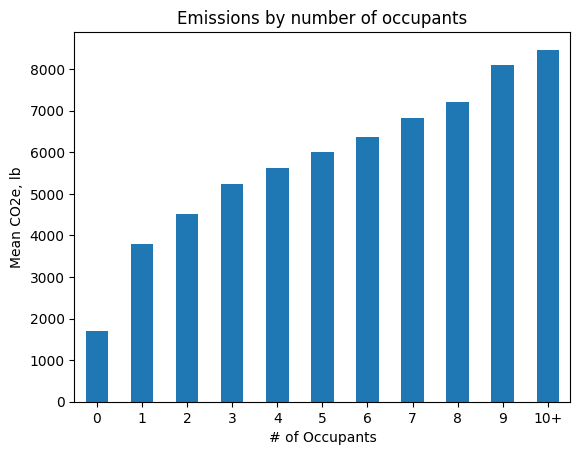

In [8]:
import matplotlib.pyplot as plt

grouped = df.groupby('build_existing_model.occupants')['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].mean()

# Sort the data based on the mean values in ascending order
grouped_sorted = grouped.sort_values()

# Generate bar graph for each group
ax = grouped_sorted.plot(kind='bar')
plt.ylabel('Mean CO2e, lb')
plt.xlabel('# of Occupants')
plt.title('Emissions by number of occupants')
ax.set_xticklabels(grouped_sorted.index, rotation=0)
plt.show()

# Actual plots

C:\Users\pshrest2\AppData\Local\Temp\1\ipykernel_22868\3201039996.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('Reds', len(grouped_sorted))


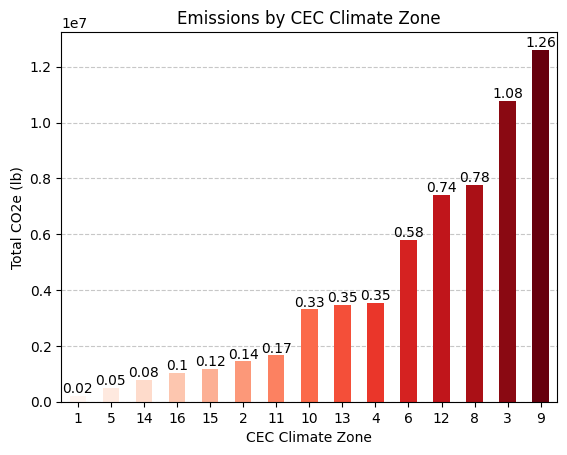

In [28]:
import matplotlib.pyplot as plt

grouped_by_cec = df.groupby('build_existing_model.cec_climate_zone')['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum()

# Sort the data based on the total values in ascending order
grouped_sorted = grouped_by_cec.sort_values()

# Create a color map ranging from lighter to darker red
color_map = plt.cm.get_cmap('Reds', len(grouped_sorted))

# Generate bar graph for each group
ax = grouped_sorted.plot(kind='bar', color=[color_map(i) for i in range(len(grouped_sorted))])
plt.ylabel('Total CO2e (lb)')
plt.xlabel('CEC Climate Zone')
plt.title('Emissions by CEC Climate Zone')
ax.set_xticklabels(grouped_sorted.index, rotation=0)

# Add data labels above each bar
# for idx, value in enumerate(grouped_sorted):
#     ax.annotate(str(round(value, 2)), xy=(idx, value), ha='center', va='bottom')

# Send gridlines behind the bars
ax.set_axisbelow(True)
# Show major gridlines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add data labels above each bar in scientific notation
for idx, value in enumerate(grouped_sorted):
    #scientific_value = '{:.2e}'.format(value)
    value_annotation = round(value/1e7,2)
    ax.annotate(value_annotation, xy=(idx, value), ha='center', va='bottom')

plt.show()


C:\Users\pshrest2\AppData\Local\Temp\1\ipykernel_22868\865074477.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10')


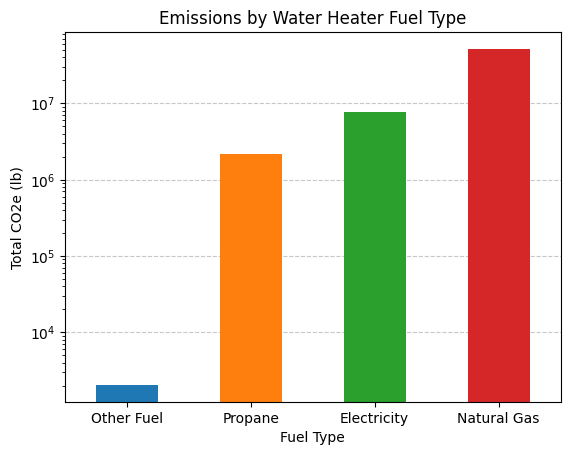

In [30]:
# Grouped by water heater fuel:

grouped_by_fuel = df.groupby('build_existing_model.water_heater_fuel')['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum()

# Sort the data based on the total values in ascending order
grouped_sorted = grouped_by_fuel.sort_values()

# Choose a color map
color_map = plt.cm.get_cmap('tab10') 

# Generate bar graph for each group
ax = grouped_sorted.plot(kind='bar', color=color_map(range(len(grouped_sorted))))
plt.ylabel('Total CO2e (lb)')
plt.xlabel('Fuel Type')
plt.title('Emissions by Water Heater Fuel Type')
ax.set_xticklabels(grouped_sorted.index, rotation=0)
# Set y-axis to log scale
ax.set_yscale('log')
# Send gridlines behind the bars
ax.set_axisbelow(True)
# Show major gridlines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add data labels above each bar in scientific notation
# for idx, value in enumerate(grouped_sorted):
#     #scientific_value = '{:.2e}'.format(value)
#     value_annotation = round(value/1e7,2)
#     ax.annotate(value_annotation, xy=(idx, value), ha='center', va='bottom')

plt.show()

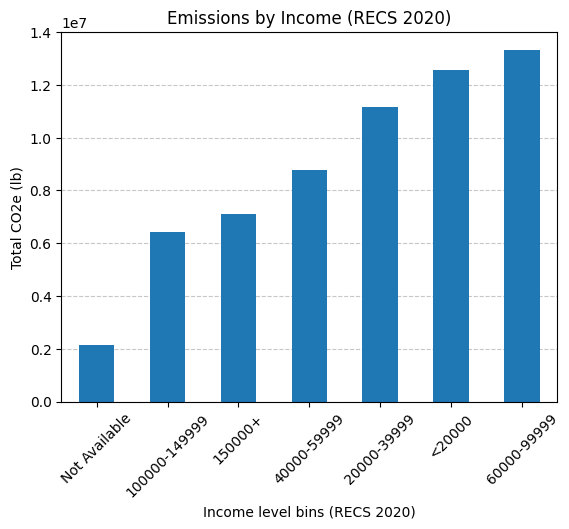

In [39]:
# Grouped by 'build_existing_model.income_recs_2020':

grouped = df.groupby('build_existing_model.income_recs_2020')['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum()

# Sort the data based on the total values in ascending order
grouped_sorted = grouped.sort_values()

# Generate bar graph for each group
ax = grouped_sorted.plot(kind='bar')
plt.ylabel('Total CO2e (lb)')
plt.xlabel('Income level bins (RECS 2020)')
plt.title('Emissions by Income (RECS 2020)')
ax.set_xticklabels(grouped_sorted.index, rotation=45)

# Send gridlines behind the bars
ax.set_axisbelow(True)
# Show major gridlines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()


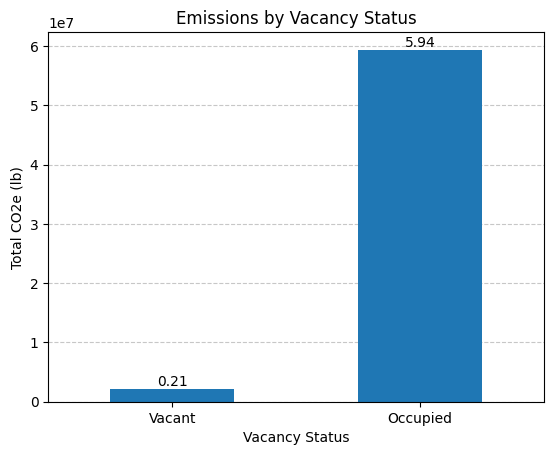

In [50]:
# Grouped by vacancy status:

grouped = df.groupby('build_existing_model.vacancy_status')['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum()

# Sort the data based on the total values in ascending order
grouped_sorted = grouped.sort_values()

# Generate bar graph for each group
ax = grouped_sorted.plot(kind='bar')
plt.ylabel('Total CO2e (lb)')
plt.xlabel('Vacancy Status')
plt.title('Emissions by Vacancy Status')
ax.set_xticklabels(grouped_sorted.index, rotation=0)

# Send gridlines behind the bars
ax.set_axisbelow(True)
# Show major gridlines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add data labels above each bar in scientific notation
for idx, value in enumerate(grouped_sorted):
    #scientific_value = '{:.2e}'.format(value)
    value_annotation = round(value/1e7,2)
    ax.annotate(value_annotation, xy=(idx, value), ha='center', va='bottom')

plt.show()